<a href="https://colab.research.google.com/github/ang-bill/IU-DLMDSME01-Credit-Card-Fraud-Detection/blob/main/Task1_Credit_Card_Fraud_Detection_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 2. Classifier 1

## Section 2A. Retrieve Dataset from Kaggle Hub
At the first run, the dataset is downloaded from Kaggle and stored locally. Subsequent runs check whether the file already exists.
See: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data


In [69]:
import os
import pandas as pd # Pandas dataframe
import kagglehub # Kagglehub to access dataset
import shutil # Util for copying files
from google.colab import drive # Import Google Drive utilities

# Mount Google Drive for persistent storage
drive.mount('/content/drive')
local_storage_base_dir = "/content/drive/MyDrive"

# Dataset details
kaggle_dataset_id = "Colab_Kaggle_Data/mlg-ulb/creditcardfraud"
file_name_in_dataset = "creditcard.csv"

# Construct the full path to locally stored dataset
local_dataset_dir = os.path.join(local_storage_base_dir, *kaggle_dataset_id.split('/'))
full_local_file_path = os.path.join(local_dataset_dir, file_name_in_dataset)

# Ensure the desired local storage directory exists
os.makedirs(local_dataset_dir, exist_ok=True)

df = None # Initialize pandas df

# Check if the file already exists in local storage, otherwise download from Kaggle
if os.path.exists(full_local_file_path):
    print(f"'{file_name_in_dataset}' found locally at '{full_local_file_path}'. Loading from there.")
else:
    print(f"'{file_name_in_dataset}' not found locally. Attempting to download from KaggleHub and store it.")

    # Use kagglehub.dataset_download to get the dataset.
    downloaded_source_root = kagglehub.dataset_download(kaggle_dataset_id)

    # Construct the path to the file within the KaggleHub download location
    source_file_path = os.path.join(downloaded_source_root, file_name_in_dataset)

    if os.path.exists(source_file_path):
        print(f"Dataset found at KaggleHub resolved location: '{source_file_path}'.")
        print(f"Copying '{file_name_in_dataset}' to local path: '{full_local_file_path}'.")

        # Copy the file to local storage location
        shutil.copy(source_file_path, full_local_file_path)

    else:
        raise FileNotFoundError(f"Failed to find '{file_name_in_dataset}' at source '{source_file_path}' after KaggleHub download resolution.")

# Load the dataset into a pandas dataframe
df = pd.read_csv(full_local_file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'creditcard.csv' found locally at '/content/drive/MyDrive/Colab_Kaggle_Data/mlg-ulb/creditcardfraud/creditcard.csv'. Loading from there.


## Section 2B. Utility functions and classes

### 1. Install dependencies
(not included in default Colab Notebook)

In [70]:
pip install pyod

### 2. Customised Class on Feature Engineering

#### HourExtractor
Extract 'Hour' from 'Time' feature to capture diurnal patterns and create a new feature. Drop 'Time' feature to avoid correlation.

In [71]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class HourExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()

        # Convert seconds to hour of day (0-23)
        X_copy['Hour'] = (X_copy['Time'] % (60*60*24)) // (60*60)

        # Drop the original Time feature
        X_copy.drop(columns=['Time'], inplace=True)

        return X_copy

#### DayNightExtractor
Extract 'Is_Night' from 'Time' feature to capture diurnal patterns and create a new feature. Drop 'Time' feature to avoid correlation.

In [72]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class DayNightExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()

        # Is_Night (Binary): 1 if between 24:00 and 08:00 (convert to hours first)
        X_copy['Is_Night'] = (((X_copy['Time'] % (60*60*24)) // (60*60)) <= 8)
        X_copy['Is_Night'] = X_copy['Is_Night'].astype(int)

        # Drop the original Time feature
        X_copy.drop(columns=['Time'], inplace=True)

        return X_copy

#### LogAmountExtractor
Extract 'Log_Amount' from 'Amount' to handle the extreme skew and create a new feature.  Drop 'Amount' feature to avoid correlation.

In [73]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class LogAmountExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()

        # np.log1p to avoid log(0) errors
        X_copy['Log_Amount'] = np.log1p(X_copy['Amount'])

        # Drop the original Amount feature
        X_copy.drop(columns=['Amount'], inplace=True)

        return X_copy

#### V14V17InteractionExtractor
Extract a combined feature from V14 and V17 to capture diagonal patterns and create a new feature.

In [74]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class V14V17InteractionExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()

        X_copy['V14_V17'] = X_copy['V14'] * X_copy['V17']

        return X_copy

### Find optimal threshold
Find optimal threshold precicion-recall curve by maximising F1 score.

In [75]:
def find_optimal_threshold(y, y_proba):
  if len(np.unique(y)) == 2:
    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y, y_proba)

    # Compute F1 for all thresholds
    numerator = 2 * precision * recall
    denominator = precision + recall
    fscores = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0)

    # Find index of max F1 score
    ix = np.argmax(fscores)

    # Get the threshold corresponding to max F1
    if ix < len(thresholds):
        return thresholds[ix]
    else:
        return 0.5 # Fallback



### Plot Precision-Recall-Curve and AUPRC
Plot the mean Precision-Recall Curve with standard deviation shading (indicating robustness) and add the mean Area Under the Precision-Recall Curve (AUPRC).

In [76]:
# Visualisation
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

def plot_pr_curves_with_std(plotting_data, title="Precision-Recall Curve", save_path=None):
    plt.figure(figsize=(10, 8))

    # Iterate over each configuration (e.g., "Naive", "XGBoost + RUS", etc.)
    for name, data in plotting_data.items():
        y_real_folds = data['y_real']
        y_proba_folds = data['y_proba']

        # Interpolate precision at these fixed recall points
        mean_recall = np.linspace(0, 1, 100)
        precisions = []

        # Process every fold
        for y_true, y_scores in zip(y_real_folds, y_proba_folds):
            # Calculate PR curve for this fold
            precision, recall, _ = precision_recall_curve(y_true, y_scores)

            # Interpolate precision to match the fixed mean_recall grid
            interp_precision = np.interp(mean_recall, recall[::-1], precision[::-1])
            precisions.append(interp_precision)

        # Convert to array for stats
        precisions = np.array(precisions)

        # Calculate Mean and SD
        mean_precision = np.mean(precisions, axis=0)
        std_precision = np.std(precisions, axis=0)

        # Calculate Mean AUC (Area Under Curve) - Average Precision
        mean_auc = auc(mean_recall, mean_precision)

        # Plotting
        p = plt.plot(mean_recall, mean_precision,
                     label=f"{name} (AUC = {mean_auc:.3f})",
                     linewidth=2, alpha=0.9)

        # Add shading for standard deviation (indicating robustness)
        plt.fill_between(mean_recall,
                         np.maximum(mean_precision - std_precision, 0),
                         np.minimum(mean_precision + std_precision, 1),
                         color=p[0].get_color(), alpha=0.15)

    # Decoration
    plt.xlabel('Recall (Sensitivity)', fontsize=12)
    plt.ylabel('Precision (Positive Predictive Value)', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2, fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.02])

    # Save to file
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\nPlot saved to: {save_path}\n")

    plt.show()

### 9. Plot Confusion Matrices
Plot confusion matrix for each configuration (averaged over repeats of K-fold Stratified Cross-Validation), by utilising optimised threshold.

*   Line 1: mean counts +/- SD (across folds)
*   Line 2: recall percentage (row-normalized)



In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import math
import textwrap

def plot_confusion_matrices(plot_data, title="Confusion Matrices", save_path=None):
    n_configs = len(plot_data)
    cols = 3
    rows = math.ceil(n_configs / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(9, 2.5 * rows))
    axes = axes.flatten()

    # Iterate over each configuration (e.g., "Naive", "XGBoost + RUS", etc.)
    for idx, (config_name, data) in enumerate(plot_data.items()):
        ax = axes[idx]

        # Collect CMs from every fold
        fold_cms = []
        for y_true_fold, y_pred_fold in zip(data['y_real'], data['y_pred']):
            fold_cms.append(confusion_matrix(y_true_fold, y_pred_fold))

        fold_cms = np.array(fold_cms)

        # Calculate Mean and Standard Deviation across CMs
        cm_mean = np.mean(fold_cms, axis=0)
        cm_std = np.std(fold_cms, axis=0)

        # Calculate Row-Normalized percentages (Recall)
        row_sums = cm_mean.sum(axis=1) # axis=1: row sum (True labels)
        cm_norm = cm_mean / row_sums[:, np.newaxis]

        # Create labels
        labels = np.empty((2, 2), dtype=object)
        for i in range(2):      # Row (True label)
            for j in range(2):  # Col (Predicted label)
                mean_val = cm_mean[i, j]
                std_val = cm_std[i, j]
                pct_val = cm_norm[i, j]

                # Line 1: mean counts +/- SD
                # Line 2: recall percentage in italics
                label = f"{mean_val:.0f} $\\pm$ {std_val:.0f}\n" + \
                        f"$\\mathit{{({pct_val*100:.2f}\\%)}}$"
                labels[i, j] = label

        # Plot Heatmap
        # Color: cm_norm to visualizes recall/precision intensity
        sns.heatmap(cm_norm, annot=labels, fmt='', cmap='Blues', cbar=False,
                    ax=ax, xticklabels=['Legit', 'Fraud'],
                    yticklabels=['Legit', 'Fraud'], annot_kws={"size": 11})

        # Decoration
        wrapped_name = "\n".join(textwrap.wrap(config_name, width=30))
        ax.set_title(f"{wrapped_name}", fontsize=11, fontweight='bold')
        ax.set_ylabel('True Label')
        ax.set_xlabel('Predicted Label')

    # Turn off empty subplots if any
    for i in range(idx + 1, len(axes)):
        axes[i].axis('off')

    # Decoration
    plt.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout(h_pad=4, w_pad=4)

    # Save as file
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Confusion Matrix plot saved to: {save_path}")

    plt.show()

### Output Hyperparameters

In [78]:
def print_param_grid(params):
    print("--- Hyperparameters ---")
    for key, val in params.items():
        # Handle 'dist' attributes
        if hasattr(val, 'dist'):
            dist_name = val.dist.name
            args = val.args

            # Format based on distribution type
            if dist_name == 'randint':
                # args = (low, high)
                val_str = f"randint range [{args[0]}, {args[1]})"
            elif dist_name == 'uniform':
                # args = (loc, scale) -> Range is [loc, loc + scale]
                val_str = f"uniform range [{args[0]}, {args[0] + args[1]}]"
            elif dist_name == 'reciprocal': # loguniform
                # args = (a, b)
                val_str = f"loguniform range [{args[0]}, {args[1]}]"
            else:
                val_str = f"{dist_name}{args}"
        else:
            # Standard list or fixed value
            val_str = str(val)

        print(f"{key:<20} : {val_str}")


### Viszualize and store ablation study result

In [79]:
import os
import sys
from datetime import datetime
from contextlib import redirect_stdout

def visualize_results_ablation_study(exp_name, params, df_results, plot_data):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    print(f"\n=== Ablation Study Results: {exp_name} ===\n")
    print(f"Date: {timestamp}\n")
    print_param_grid(params)
    print("\n--- Metrics ---\n")
    print(df_results.to_markdown(index=False))

    # e.g., "experiments/20251211_204500_XGBoost_V5_NoRUS_report.txt"
    report_file = os.path.join(local_results_dir, f"{timestamp}_{exp_name}_report.txt")
    report_excel_file = os.path.join(local_results_dir, f"{timestamp}_{exp_name}_clcomp_report.xlsx")

    auprc_file = os.path.join(local_results_dir, f"{timestamp}_{exp_name}_auprc.png")
    auprc_fe_all_file = os.path.join(local_results_dir, f"{timestamp}_{exp_name}_auprc_fe_all.png")
    auprc_fe_1_file = os.path.join(local_results_dir, f"{timestamp}_{exp_name}_auprc_fe_1.png")
    auprc_fe_2_file = os.path.join(local_results_dir, f"{timestamp}_{exp_name}_auprc_fe_2.png")
    auprc_fe_3_file = os.path.join(local_results_dir, f"{timestamp}_{exp_name}_auprc_fe_3.png")
    auprc_fe_4_file = os.path.join(local_results_dir, f"{timestamp}_{exp_name}_auprc_fe_4.png")
    auprc_scaling_file = os.path.join(local_results_dir, f"{timestamp}_{exp_name}_auprc_scaling.png")
    auprc_rus_file = os.path.join(local_results_dir, f"{timestamp}_{exp_name}_auprc_rus.png")
    auprc_cw_file = os.path.join(local_results_dir, f"{timestamp}_{exp_name}_auprc_cw.png")
    auprc_opt_file = os.path.join(local_results_dir, f"{timestamp}_{exp_name}_auprc_opt.png")
    auprc_c1_file = os.path.join(local_results_dir, f"{timestamp}_{exp_name}_auprc_c1.png")
    auprc_c2_file = os.path.join(local_results_dir, f"{timestamp}_{exp_name}_auprc_c2.png")
    auprc_c3_file = os.path.join(local_results_dir, f"{timestamp}_{exp_name}_auprc_c3.png")
    auprc_c4_file = os.path.join(local_results_dir, f"{timestamp}_{exp_name}_auprc_c4.png")

    cm_file = os.path.join(local_results_dir, f"{timestamp}_{exp_name}_confmatrix.png")

    # Store text report as text
    with open(report_file, "w") as f:
        f.write(f"=== Ablation Study Results: {exp_name} ===\n")
        f.write(f"Date: {timestamp}\n\n")

        f.write("--- Hyperparameters ---\n")
        with redirect_stdout(f):
            print_param_grid(params)

        f.write("\n\n--- Results Table ---\n")
        f.write(df_results.to_markdown(index=False))

    print(f"\nText report saved to: {report_file}\n")

    # Store text report additionally as Excel
    df_results.to_excel(report_excel_file, index=False)
    print(f"Excel report saved to: {report_excel_file}")

    # Plot AUPRC: all experiments
    plot_pr_curves_with_std(plot_data,
                            title=f"{exp_name}: AUPRC - All Experiments",
                            save_path=auprc_file)

    # Plot AUPRC: FE vs. no FE
    plot_pr_curves_with_std(
        {k: v for k, v in plot_data.items() if k.startswith(("1.", "2.1", "2.2", "2.3", "2.4"))},title=f"{exp_name}: AUPRC - Feature Engineering",save_path=auprc_fe_all_file)
    # Plot AUPRC: FE_1 (Hour) vs. no FE
    plot_pr_curves_with_std(
        {k: v for k, v in plot_data.items() if k.startswith(("1.", "2.1"))},title=f"{exp_name}: AUPRC - Feature Engineering Hour",save_path=auprc_fe_1_file)
    # Plot AUPRC: FE_2 (Is_Night) vs. no FE
    plot_pr_curves_with_std(
        {k: v for k, v in plot_data.items() if k.startswith(("1.", "2.2"))},title=f"{exp_name}: AUPRC - Feature Engineering Is_Night",save_path=auprc_fe_2_file)
    # Plot AUPRC: FE_3 (Log_Amount) vs. no FE
    plot_pr_curves_with_std(
        {k: v for k, v in plot_data.items() if k.startswith(("1.", "2.3"))},title=f"{exp_name}: AUPRC - Feature Engineering Log_Amount",save_path=auprc_fe_3_file)
    # Plot AUPRC: FE_4 (V14_V17) vs. no FE
    plot_pr_curves_with_std(
        {k: v for k, v in plot_data.items() if k.startswith(("1.", "2.4"))},title=f"{exp_name}: AUPRC - Feature Engineering V14_V17",save_path=auprc_fe_4_file)

    # Plot AUPRC: Scaling vs. no Scaling
    plot_pr_curves_with_std(
        {k: v for k, v in plot_data.items() if k.startswith(("1.", "2.5"))},title=f"{exp_name}: AUPRC - Scaling",save_path=auprc_scaling_file)

    # Plot AUPRC: RUS vs. no RUS
    plot_pr_curves_with_std(
        {k: v for k, v in plot_data.items() if k.startswith(("1.", "2.6"))},title=f"{exp_name}: AUPRC - Random Undersampling",save_path=auprc_rus_file)

    # Plot AUPRC: Class weight vs. no class weight
    plot_pr_curves_with_std(
        {k: v for k, v in plot_data.items() if k.startswith(("1.", "2.7"))},title=f"{exp_name}: AUPRC - Class Weight",save_path=auprc_cw_file)

    # Plot AUPRC: Optimisation vs. no Optimisation
    plot_pr_curves_with_std(
        {k: v for k, v in plot_data.items() if k.startswith(("1.", "2.8"))},title=f"{exp_name}: AUPRC - Optimisation",save_path=auprc_opt_file)

    # Plot AUPRC: Combination 1
    plot_pr_curves_with_std(
        {k: v for k, v in plot_data.items() if k.startswith(("1.", "3.1"))},title=f"{exp_name}: AUPRC - Optimisation",save_path=auprc_c1_file)
    # Plot AUPRC: Combination 2
    plot_pr_curves_with_std(
        {k: v for k, v in plot_data.items() if k.startswith(("1.", "3.2"))},title=f"{exp_name}: AUPRC - Optimisation",save_path=auprc_c2_file)
    # Plot AUPRC: Combination 3
    plot_pr_curves_with_std(
        {k: v for k, v in plot_data.items() if k.startswith(("1.", "3.3"))},title=f"{exp_name}: AUPRC - Optimisation",save_path=auprc_c3_file)
    # Plot AUPRC: Combination 4
    plot_pr_curves_with_std(
        {k: v for k, v in plot_data.items() if k.startswith(("1.", "3.4"))},title=f"{exp_name}: AUPRC - Optimisation",save_path=auprc_c4_file)

    # Plot confusion matrices
    plot_confusion_matrices(
        plot_data,
        title=f"{exp_name}: Confusion Matrices (Mean per Fold)",
        save_path=cm_file
    )

### Viszualize and store classifier comparison

In [80]:
import os
import sys
from datetime import datetime
from contextlib import redirect_stdout

def visualize_results_classifier_comparison(exp_name, df_results, plot_data):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    print(f"\n=== Classifier Comparison Results: {exp_name} ===\n")
    print(f"Date: {timestamp}\n")
    print("\n--- Metrics ---\n")
    print(df_results.to_markdown(index=False))

    # e.g., "experiments/20251211_204500_XGBoost_V5_NoRUS_report.txt"
    report_file = os.path.join(local_results_dir, f"{timestamp}_{exp_name}_clcomp_report.txt")
    report_excel_file = os.path.join(local_results_dir, f"{timestamp}_{exp_name}_clcomp_report.xlsx")

    auprc_file = os.path.join(local_results_dir, f"{timestamp}_{exp_name}_clcomp_auprc.png")

    cm_file = os.path.join(local_results_dir, f"{timestamp}_{exp_name}_clcomp_confmatrix.png")

    # Store text report as text
    with open(report_file, "w") as f:
        f.write(f"=== Classifier Comparison Results: {exp_name} ===\n")
        f.write(f"Date: {timestamp}\n\n")

        f.write("\n\n--- Results Table ---\n")
        f.write(df_results.to_markdown(index=False))

    print(f"\nText report saved to: {report_file}\n")

    # Store text report additionally as Excel
    df_results.to_excel(report_excel_file, index=False)
    print(f"Excel report saved to: {report_excel_file}")

    # Plot AUPRC: Classifier Comparison
    plot_pr_curves_with_std(plot_data,
                            title=f"{exp_name}: AUPRC",
                            save_path=auprc_file)

    # Plot Confusion Matrices
    plot_confusion_matrices(
        plot_data,
        title=f"{exp_name}: Confusion Matrices (Mean per Fold)",
        save_path=cm_file
    )

### Ablation Study (Train, Validate, and Test)
For a specific classifier, run each configuration by processing the pipeline. CV for training and validation, testing with independent test set.


*   Cross Validation Outer Loop: Repeated Stratified 5-Fold
*   Cross Validation Inner Loop: Stratified 4-Fold (used inside RandomizedSearchCV)
*   Optimisation: use RandomizedSearchCV, optimse for Area Under the Precision-Recall Curve (AUPRC)
*   Threshold tuning: after hyperparameter optimisation, maximise F1-score


Parameters of function:
*   experiment_name: String label (e.g., "XGBoost")
*   base_clf: The instantiated classifier object (e.g., XGBClassifier())
*   param_dist: Dictionary for RandomizedSearchCV
*   X, y: Data
*   configs: Dictionary of ablation study configurations


In [81]:
import numpy as np
import pandas as pd

from datetime import datetime

from sklearn.base import clone, BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import average_precision_score, make_scorer, fbeta_score, f1_score, precision_score, recall_score, brier_score_loss
from sklearn.preprocessing import RobustScaler
#from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from imblearn.pipeline import Pipeline as ImbPipeline # Supports resampling inside CV
from imblearn.under_sampling import RandomUnderSampler

def run_ablation_study(experiment_name, base_clf, param_dist, X, y, configs):
    # Cross Validation Outer Loop: 5 times repeated stratified 5-Fold
    # n_splits: split into 5 folds (4 train set, 1 test set)
    # n_repeats: repeating 5 times (different splits each iteration)
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html
    # https://scikit-learn.org/stable/modules/cross_validation.html#repeated-k-fold
    outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=397)

    # Cross Validation Inner Loop: Stratified 4-Fold (used inside RandomizedSearchCV)
    inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    results_table = []
    plotting_data = {}

    print(f"--- Starting Experiment: {experiment_name} ---")

    # Process every configuration of ablation study
    for name, cfg in configs.items():
        print(f"\n{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} Running Configuration: {name}")

        fold_metrics = {
                'f1_test': [], 'f1_train': [],
                'f2_test': [], 'f2_train': [],
                'rec_test': [], 'rec_train': [],
                'prec_test': [], 'prec_train': [],
                'auprc_test': [], 'auprc_train': [],
                'thresh': [], 'best_params': []
            }
        plotting_data[name] = {'y_real': [], 'y_proba': [], 'y_pred': []}

        # Outer CV loop (split training and test set)
        for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Build pipeline steps
            steps = []

            # Pipeline step: Feature Engineering
            if cfg['fe_1']:
                steps.append(('fe_1', HourExtractor()))
            if cfg['fe_2']:
                steps.append(('fe_2', DayNightExtractor()))
            if cfg['fe_3']:
                steps.append(('fe_3', LogAmountExtractor()))
            if cfg['fe_4']:
                steps.append(('fe_4', V14V17InteractionExtractor()))

            # Pipeline step: Scaling (RobustScaler)
            if cfg['scale']:
                steps.append(('scaler', RobustScaler()))

            # Pipeline step: Resampling (RUS)
            # Resampling in the pipeline preventes data leakage
            # Resampling is only applied to the traning fold inside
            # (https://imbalanced-learn.org/stable/common_pitfalls.html)
            if cfg['rus']:
                steps.append(('rus', RandomUnderSampler(sampling_strategy=1.0, random_state=42)))

            # Pipeline step: Classifier
            final_clf = clone(base_clf)

            # Set class weight of classifier
            if cfg.get('class_weight'):
                if hasattr(final_clf, 'scale_pos_weight'):
                    # Calculate ratio for XGBoost: Negatives / Positives
                    # https://xgboost.readthedocs.io/en/stable/parameter.html
                    ratio = (len(y_train) - y_train.sum()) / y_train.sum()
                    final_clf.set_params(scale_pos_weight=ratio)
                    print(f"\nXGBoost scale_pos_weight: {ratio}")
                else:
                    # For Logistic Regression
                    final_clf.set_params(class_weight='balanced')
                    print(f"\nLogistic Regression class_weight: balanced")
            else:
                if hasattr(final_clf, 'scale_pos_weight'):
                  final_clf.set_params(scale_pos_weight=1)
                  print(f"\nXGBoost scale_pos_weight: 1")
                else:
                  final_clf.set_params(class_weight=None)
                  print(f"\nLogistic Regression class_weight: None")

            steps.append(('clf', final_clf))

            # Create pipeline from steps
            pipeline = ImbPipeline(steps)

            # Optimisation (Inner CV Loop)
            if cfg['opt']:
                iterations = 50 if cfg['rus'] else 20

                # In case of RUS, modify parameters to avoid warning
                current_param_dist = param_dist.copy()
                if cfg['rus']:
                  # XGBoost: delete parameter scale_pos_weight
                  current_param_dist.pop('scale_pos_weight', None)
                  # Logistic Regression: delete parameter class_weight
                  current_param_dist.pop('class_weight', None)

                # Update param_dist keys to match current pipeline structure
                tuned_params = {f"clf__{k}":
                                v for k, v in current_param_dist.items()}

                # RandomizedSearchCV, optimize for AUPRC (average_precision)
                search = RandomizedSearchCV(pipeline, tuned_params,
                                            n_iter=iterations,
                                            scoring='average_precision',
                                            cv=inner_cv, n_jobs=-1,
                                            random_state=267)
                search.fit(X_train, y_train)
                model = search.best_estimator_
            else:
                pipeline.fit(X_train, y_train)
                model = pipeline

            # Prediction on test set
            y_pred_test = model.predict(X_test)

            # Store probabilities for visualisation
            y_proba_test = model.predict_proba(X_test)[:, 1] # calibrated probabilities
            y_proba_train = model.predict_proba(X_train)[:, 1]

            # Threshold tuning:
            # Find optimal threshold (max F1 score) on training data
            best_thresh_train = find_optimal_threshold(y_train, y_proba_train)
            fold_metrics['thresh'].append(best_thresh_train)

            # Apply this threshold to test data
            y_pred_test_tuned = (y_proba_test >= best_thresh_train).astype(int)

            # Prediction also on training set
            # This enables the measurement of the generalization gap between
            # the training and the test accuracy to control overfitting. See
            # https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html
            # Test metrics: measures performance on test data (never seen by model)
            # Training metrics: measures performance on training data (all inner
            #                   folds of CV)
            y_pred_train_tuned = (y_proba_train >= best_thresh_train).astype(int)

            plotting_data[name]['y_real'].append(y_test)
            plotting_data[name]['y_proba'].append(y_proba_test)
            plotting_data[name]['y_pred'].append(y_pred_test_tuned)

            # Record Metrics on test set (using optimal threshold)
            fold_metrics['f1_test'].append(f1_score(y_test, y_pred_test_tuned))
            fold_metrics['f2_test'].append(fbeta_score(y_test, y_pred_test_tuned, beta=2))
            fold_metrics['rec_test'].append(recall_score(y_test, y_pred_test_tuned))
            fold_metrics['prec_test'].append(precision_score(y_test, y_pred_test_tuned, zero_division=0))
            fold_metrics['auprc_test'].append(average_precision_score(y_test, y_proba_test))

            # Record metrics on training set
            fold_metrics['f1_train'].append(f1_score(y_train, y_pred_train_tuned))
            fold_metrics['f2_train'].append(fbeta_score(y_train, y_pred_train_tuned, beta=2))
            fold_metrics['rec_train'].append(recall_score(y_train, y_pred_train_tuned))
            fold_metrics['prec_train'].append(precision_score(y_train, y_pred_train_tuned, zero_division=0))
            fold_metrics['auprc_train'].append(average_precision_score(y_train, y_proba_train))

            # Record best optimisation parameters
            if cfg['opt']:
              fold_metrics['best_params'].append(search.best_params_)
              print(pd.DataFrame([search.best_params_]).to_markdown(index=False))

        # Aggregate results for this configuration
        row = {'Configuration': name}
        metrics_map = {
          'f1': 'F1 Score',
          'f2': 'F2 Score',
          'rec': 'Recall',
          'prec': 'Precision',
          'auprc': 'AUPRC',
          }

        # Calculate and store metrics
        for key, label in metrics_map.items():
          test_scores = fold_metrics[f'{key}_test']
          train_scores = fold_metrics[f'{key}_train']

          # Calculate Mean
          test_mean = np.mean(test_scores)
          train_mean = np.mean(train_scores)

          # Calculate SD (standard deviation)
          # A large SD indicates data sensitivity (i.e. low robustness)
          test_std  = np.std(test_scores)
          if test_mean > 0:
              cv_pct = (test_std / test_mean) * 100  # Coefficient of Variation
          else:
              cv_pct = 0.0

          # Calculate Gap (Train - Test)
          # Large gap indicates overfitting (i.e. low generalization)
          gap = train_mean - test_mean
          if test_mean > 0:
            gap_pct = (gap / test_mean) * 100      # Relative Overfitting
          else:
            gap_pct = 0.0

          # Add Columns to Row
          row[f'{label} (Mean)'] = f"{test_mean:.4f}"
          row[f'{label} (SD)']   = f"{test_std:.4f}"
          row[f'{label} (SD%)']   = f"{cv_pct:.1f}"
          row[f'{label} (Gap)']   = f"{gap:.4f}"
          row[f'{label} (Gap%)']   = f"{gap_pct:.1f}"

        # Calculate mean and sd for optimal thresholds
        test_mean = np.mean(fold_metrics['thresh'])
        test_std = np.std(fold_metrics['thresh'])
        row[f'Opt Thresh (Mean)'] = f"{test_mean:.4f}"
        row[f'Opt Thresh (SD)']   = f"{test_std:.4f}"

        # Calculate mean and sd for hyperparameters
        params_df = pd.DataFrame(fold_metrics['best_params'])
        numeric_params_df = params_df.select_dtypes(include=[np.number])
        mean_params = numeric_params_df.mean()
        sd_params = numeric_params_df.std(ddof=1) # Use ddof=1 for sample SD

        for param_name in mean_params.index:
            mean_val = mean_params[param_name]
            sd_val = sd_params[param_name]

            base_name = param_name.split('__')[-1] # Extracts 'C' from 'clf__C'

            row[f'{base_name} (Mean)'] = f"{mean_val:.4f}"
            row[f'{base_name} (SD)'] = f"{sd_val:.4f}"

        # Append row to the results table
        print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        print(pd.DataFrame([row]).to_markdown(index=False))
        results_table.append(row)

    # Return result
    return pd.DataFrame(results_table), plotting_data

## Section 2C. Initialization

### Basic Init

In [63]:
import warnings
# Supress the specific warning from imblearn pipeline (supress as pipeline works correctly)
warnings.filterwarnings("ignore", category=FutureWarning, module="imblearn.pipeline")
# Suppress the specific feature name warning from sklearn
warnings.filterwarnings("ignore", message="X has feature names, but IsolationForest was fitted without feature names")

# Dataset details
results_dir = "Colab_Results/creditcardfraud"

# Construct the full path to locally stored dataset
local_results_dir = os.path.join(local_storage_base_dir, *results_dir.split('/'))
os.makedirs(local_results_dir, exist_ok=True)

### Create features and labels

In [64]:
X = df.drop('Class', axis=1)  # features
y = df['Class'] # Labels
original_fraud_rate = np.mean(y)

print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} Dataset Shape: {X.shape}, Fraud Ratio: {np.mean(y):.4}")

2025-12-22 16:34:14 Dataset Shape: (284807, 30), Fraud Ratio: 0.001727


### Configuration of pipelines
The ablation study evaluates the effect of each component separately, therefore distinct pipelines are defined.

**Components:**
*   Naive: No pre-processing
*   Feature engineering: Augmentation with Hour vs. no feature engineering
*   Data preprocessing: RobustScaler vs. no scaling
*   Resampling: RUS vs. no resampling
*   Classifier optimisation: Randomised parameter optimisation vs. using default parameters





In [65]:
# Distinct pipelines to test each component
configs = {
    # Naive classifier
    "1. Naive": {
        'fe_1': False, 'fe_2': False, 'fe_3': False, 'fe_4': False, 'scale': False, 'rus': False, 'class_weight': False, 'opt': False
    },

    # Test isolated of each component
    "2.1 FE (Hour)": {
        'fe_1': True, 'fe_2': False, 'fe_3': False, 'fe_4': False,  'scale': False, 'rus': False, 'class_weight': False, 'opt': False
    },
    "2.2 FE (Is_Night)": {
        'fe_1': False, 'fe_2': True, 'fe_3': False, 'fe_4': False,  'scale': False, 'rus': False, 'class_weight': False, 'opt': False
    },
    "2.3 FE (Log_Amount)": {
        'fe_1': False, 'fe_2': False, 'fe_3': True, 'fe_4': False,  'scale': False, 'rus': False, 'class_weight': False, 'opt': False
    },
    "2.4 FE (V14_V17)": {
        'fe_1': False, 'fe_2': False, 'fe_3': False, 'fe_4': True,  'scale': False, 'rus': False, 'class_weight': False, 'opt': False
    },
    "2.5 Scaling": {
        'fe_1': False, 'fe_2': False, 'fe_3': False, 'fe_4': False,  'scale': True, 'rus': False, 'class_weight': False, 'opt': False
    },
    "2.6 RUS": {
        'fe_1': False, 'fe_2': False, 'fe_3': False, 'fe_4': False,  'scale': False, 'rus': True, 'class_weight': False, 'opt': False
    },
    "2.7 Class Weight": {
        'fe_1': False, 'fe_2': False, 'fe_3': False, 'fe_4': False,  'scale': False, 'rus': False, 'class_weight': True, 'opt': False
    },
    "2.8 Optimisation": {
        'fe_1': False, 'fe_2': False, 'fe_3': False, 'fe_4': False,  'scale': False, 'rus': False, 'class_weight': False, 'opt': True
    },

    # Combinations
    "3.1 Scaling + Class Weight": {
        'fe_1': False, 'fe_2': False, 'fe_3': False, 'fe_4': False,  'scale': True, 'rus': False, 'class_weight': True, 'opt': False
    },
    "3.2 Scaling + Class Weight + Optimisation": {
        'fe_1': False, 'fe_2': False, 'fe_3': False, 'fe_4': False,  'scale': True, 'rus': False, 'class_weight': True, 'opt': True
    },
    "3.3 FE (Is_Night) + Scaling + Class Weight": {
        'fe_1': False, 'fe_2': True, 'fe_3': False, 'fe_4': False,  'scale': True, 'rus': False, 'class_weight': True, 'opt': False
    },
    "3.4 FE (Is_Night) + Scaling + Class Weight + Optimisation": {
        'fe_1': False, 'fe_2': True, 'fe_3': False, 'fe_4': False,  'scale': True, 'rus': False, 'class_weight': True, 'opt': True
    }
}

In [66]:
# Test pipelines to ease implementation
test_configs = {
    "Scaling": {
        'fe_1': False, 'fe_2': False, 'fe_3': False, 'fe_4': False, 'scale': True, 'rus': False, 'class_weight': False, 'opt': False
    },
    "Class Weight": {
        'fe_1': False, 'fe_2': False, 'fe_3': False, 'fe_4': False, 'scale': True, 'rus': False, 'class_weight': True, 'opt': False
    }
}
testopt_configs = {
    "Scaling + Optimisation": {
        'fe_1': False, 'fe_2': False, 'fe_3': False, 'fe_4': False, 'scale': True, 'rus': False, 'class_weight': True, 'opt': True
    }
}

## Section 2C. Implementation of Base Classifier - Logistic Regression



=== Ablation Study Results: Logistic Regression ===

Date: 20251222_163237

--- Hyperparameters ---
C                    : loguniform(0.0001, 1)
penalty              : ['l1', 'l2']

--- Metrics ---

| Configuration   |   F1 Score (Mean) |   F1 Score (SD) |   F1 Score (SD%) |   F1 Score (Gap) |   F1 Score (Gap%) |   F2 Score (Mean) |   F2 Score (SD) |   F2 Score (SD%) |   F2 Score (Gap) |   F2 Score (Gap%) |   Recall (Mean) |   Recall (SD) |   Recall (SD%) |   Recall (Gap) |   Recall (Gap%) |   Precision (Mean) |   Precision (SD) |   Precision (SD%) |   Precision (Gap) |   Precision (Gap%) |   AUPRC (Mean) |   AUPRC (SD) |   AUPRC (SD%) |   AUPRC (Gap) |   AUPRC (Gap%) |   Opt Thresh (Mean) |   Opt Thresh (SD) |
|:----------------|------------------:|----------------:|-----------------:|-----------------:|------------------:|------------------:|----------------:|-----------------:|-----------------:|------------------:|----------------:|--------------:|---------------:|---------------:

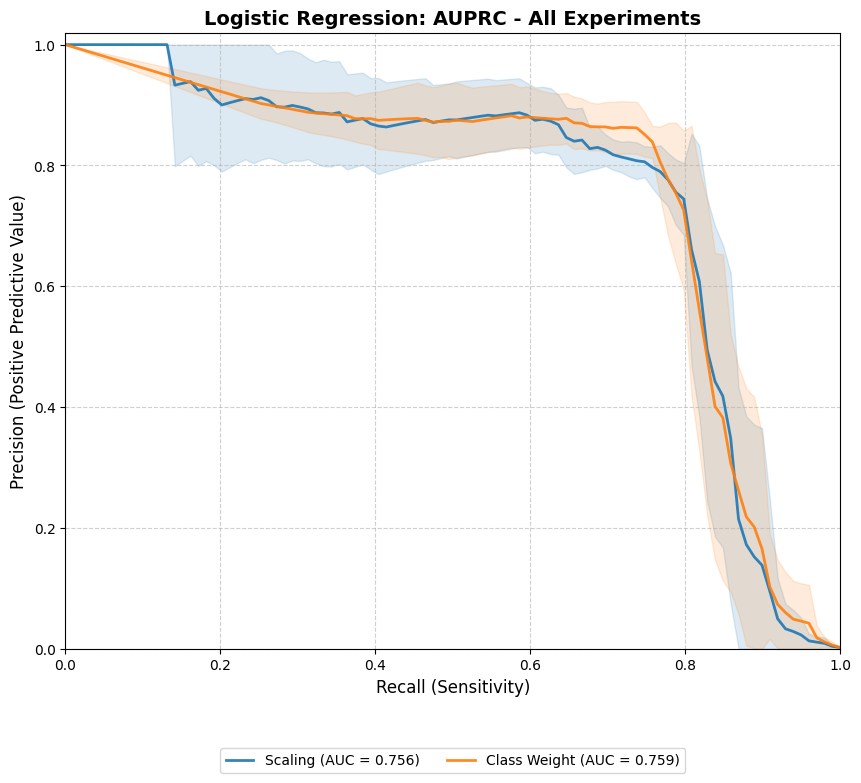

/tmp/ipython-input-1787993024.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2, fontsize=10)



Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251222_163237_Logistic Regression_auprc_fe_all.png



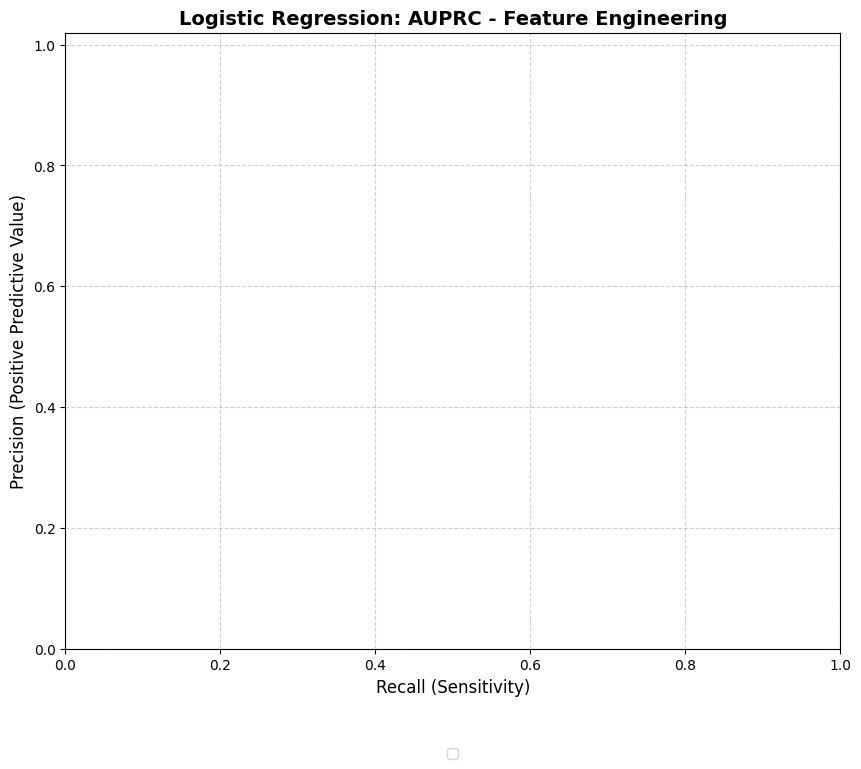


Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251222_163237_Logistic Regression_auprc_fe_1.png



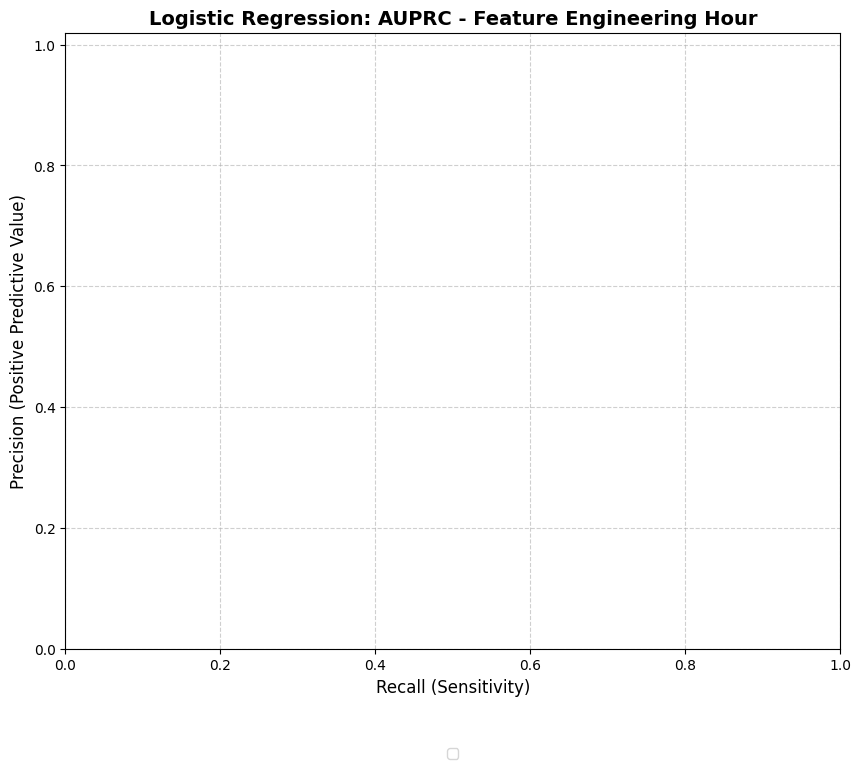


Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251222_163237_Logistic Regression_auprc_fe_2.png



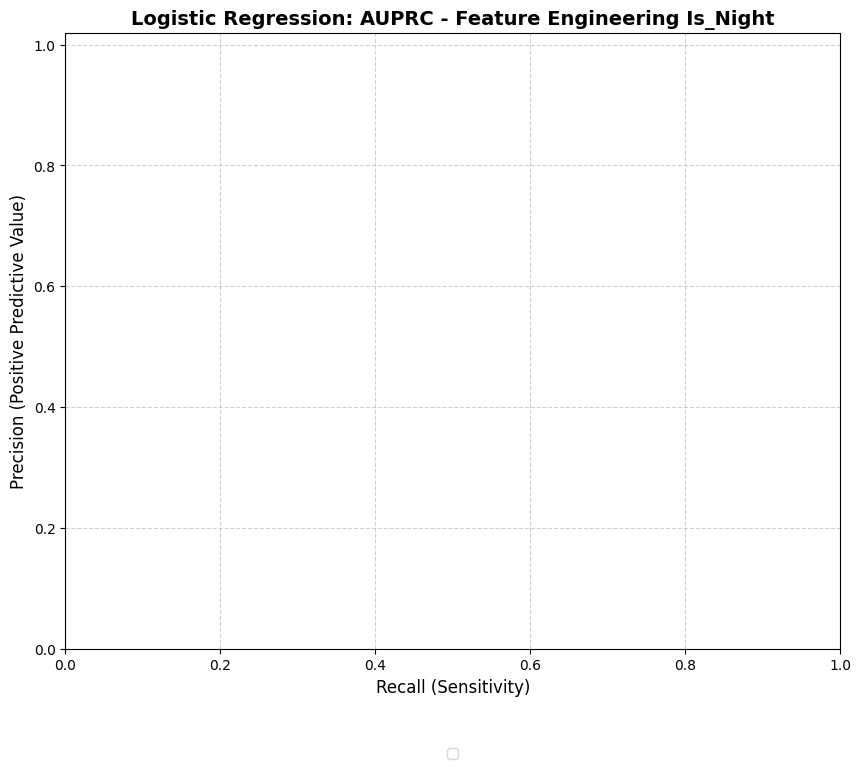


Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251222_163237_Logistic Regression_auprc_fe_3.png



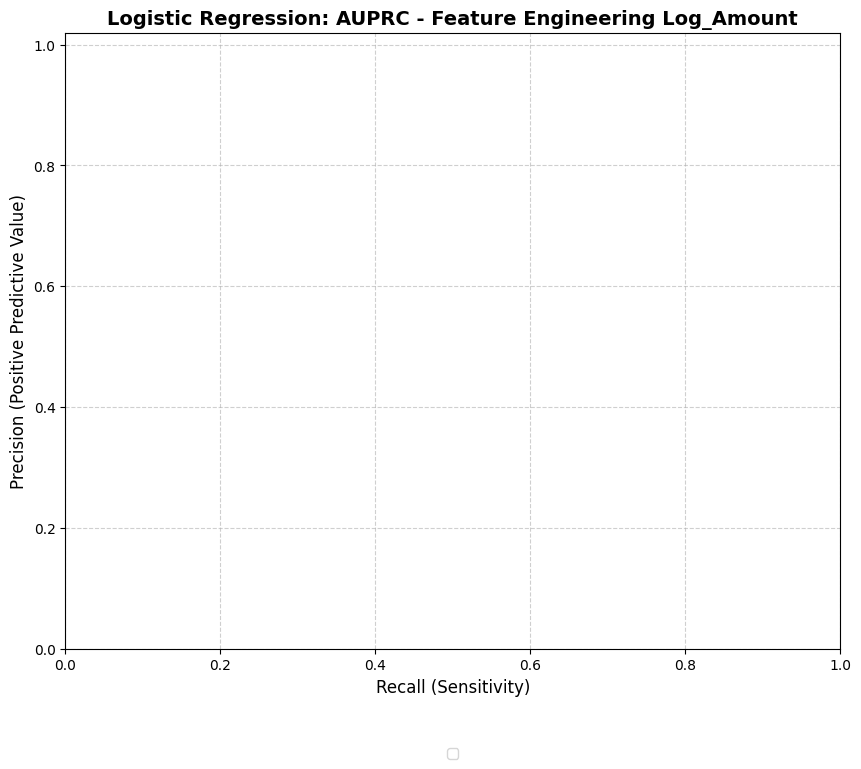


Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251222_163237_Logistic Regression_auprc_fe_4.png



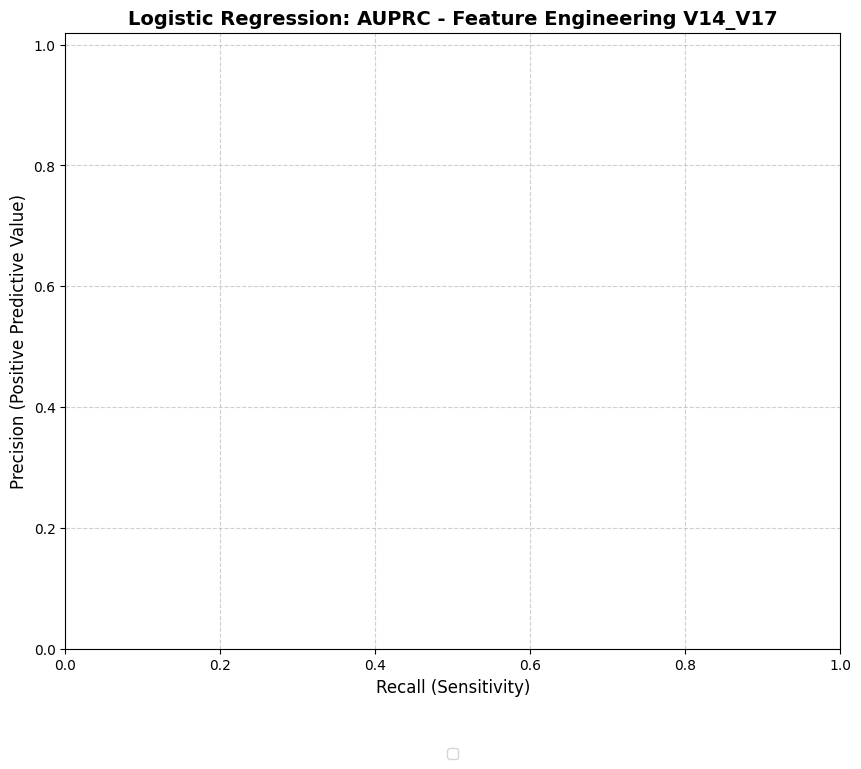


Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251222_163237_Logistic Regression_auprc_scaling.png



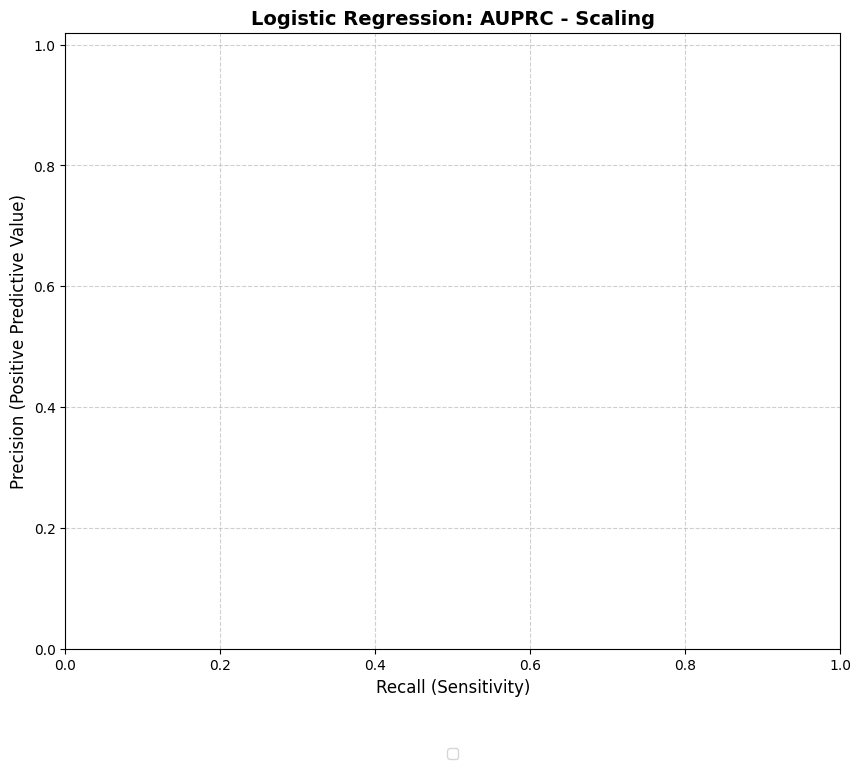


Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251222_163237_Logistic Regression_auprc_rus.png



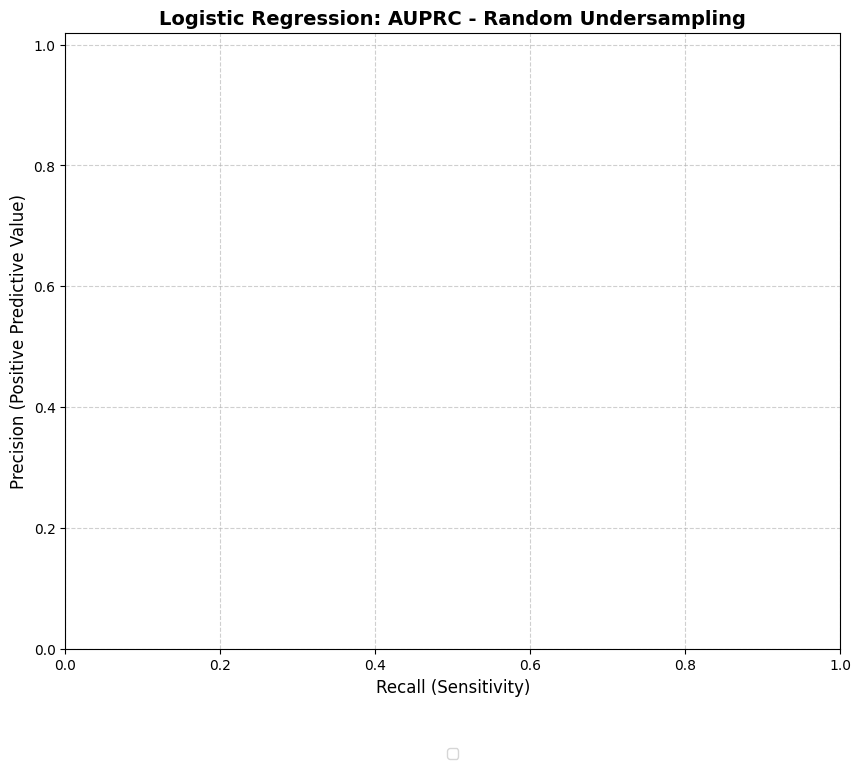


Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251222_163237_Logistic Regression_auprc_cw.png



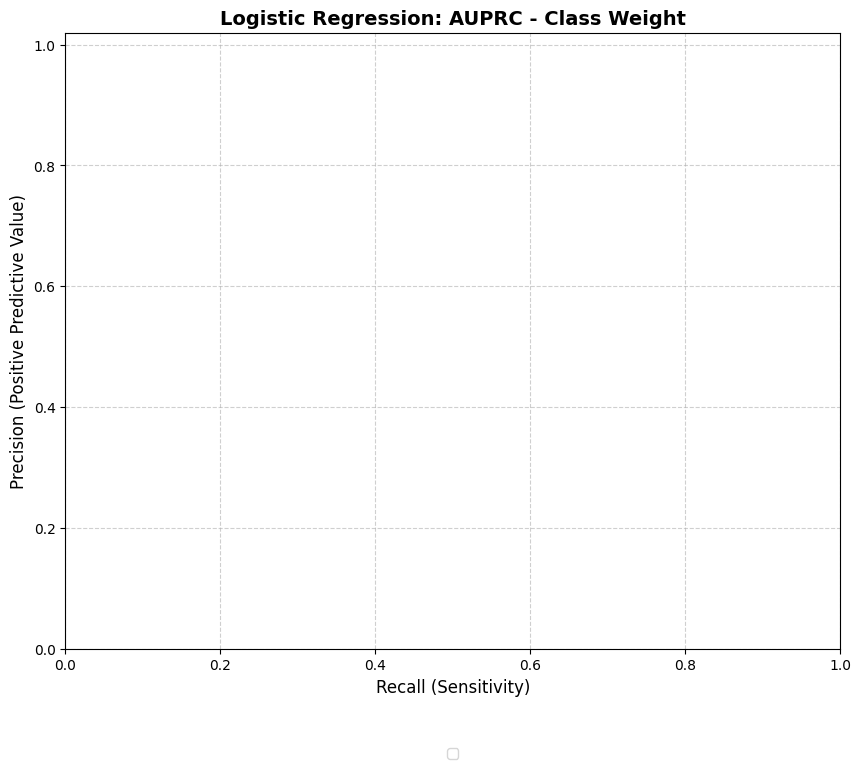


Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251222_163237_Logistic Regression_auprc_opt.png



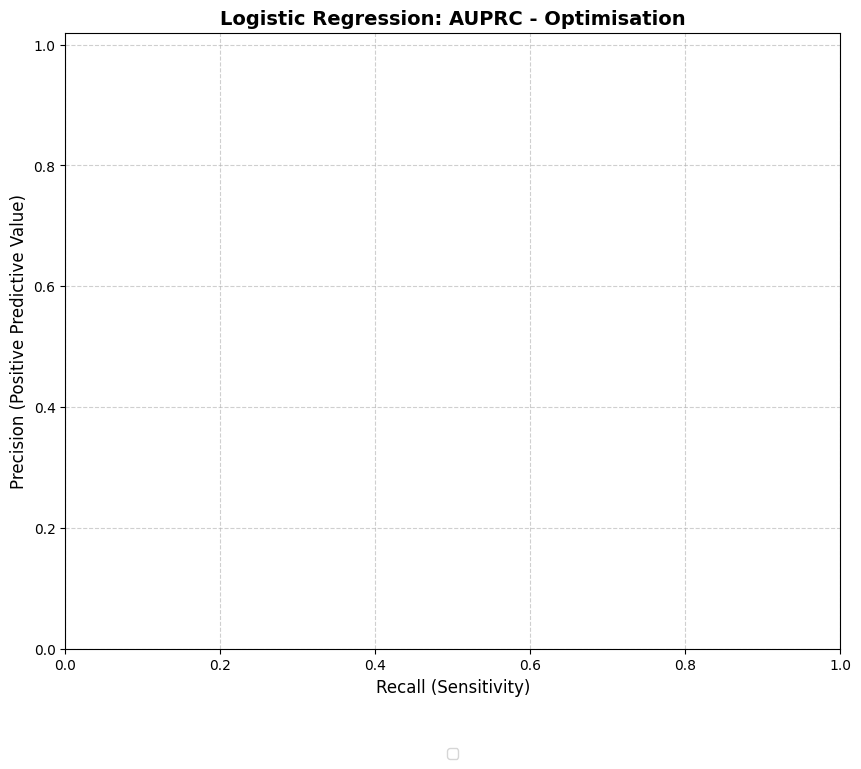


Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251222_163237_Logistic Regression_auprc_c1.png



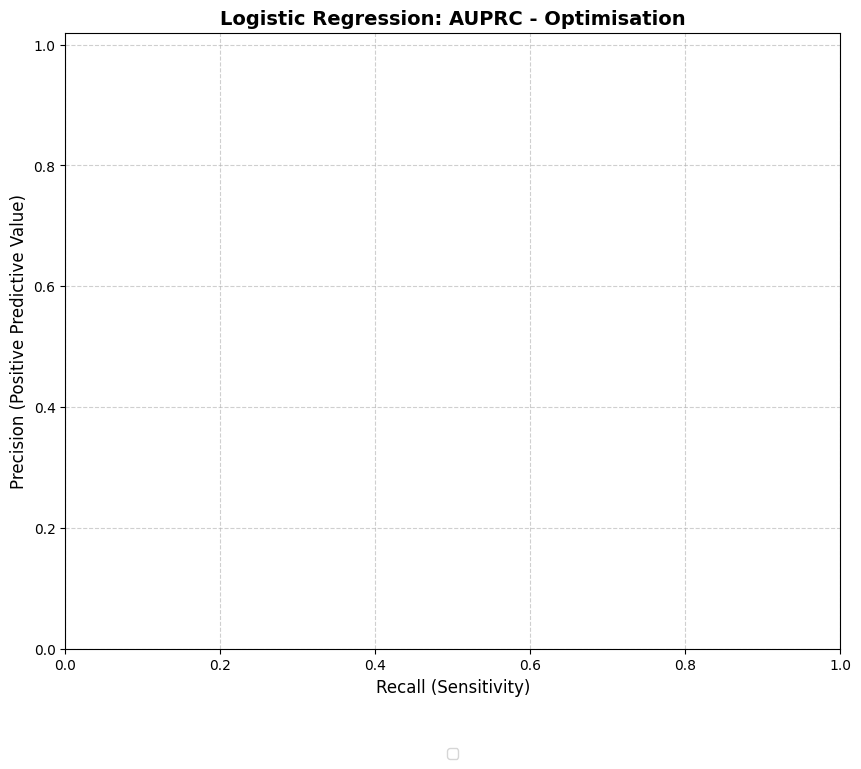


Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251222_163237_Logistic Regression_auprc_c2.png



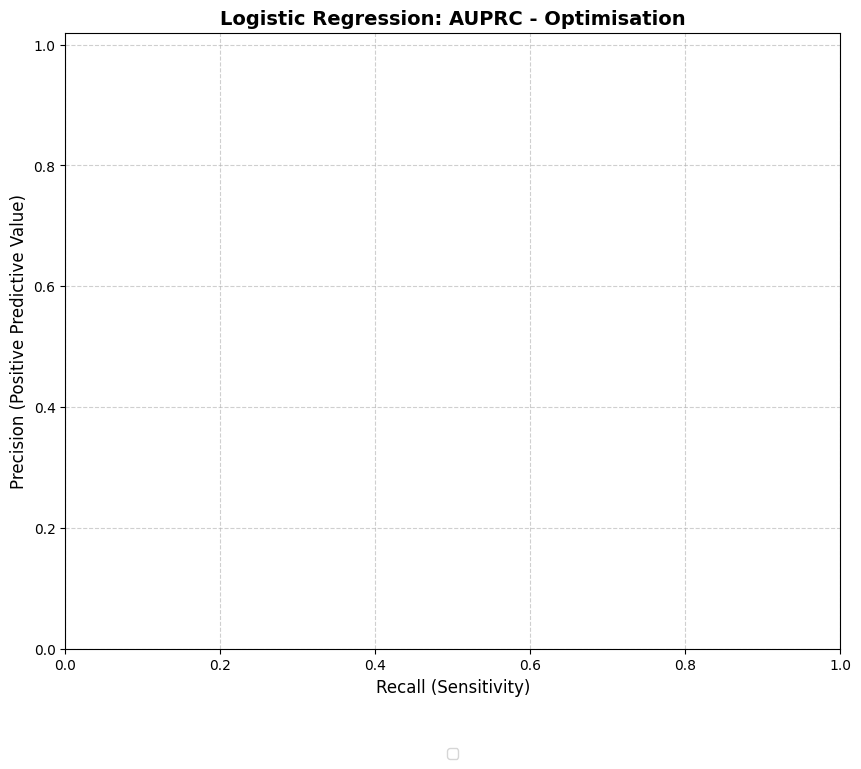


Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251222_163237_Logistic Regression_auprc_c3.png



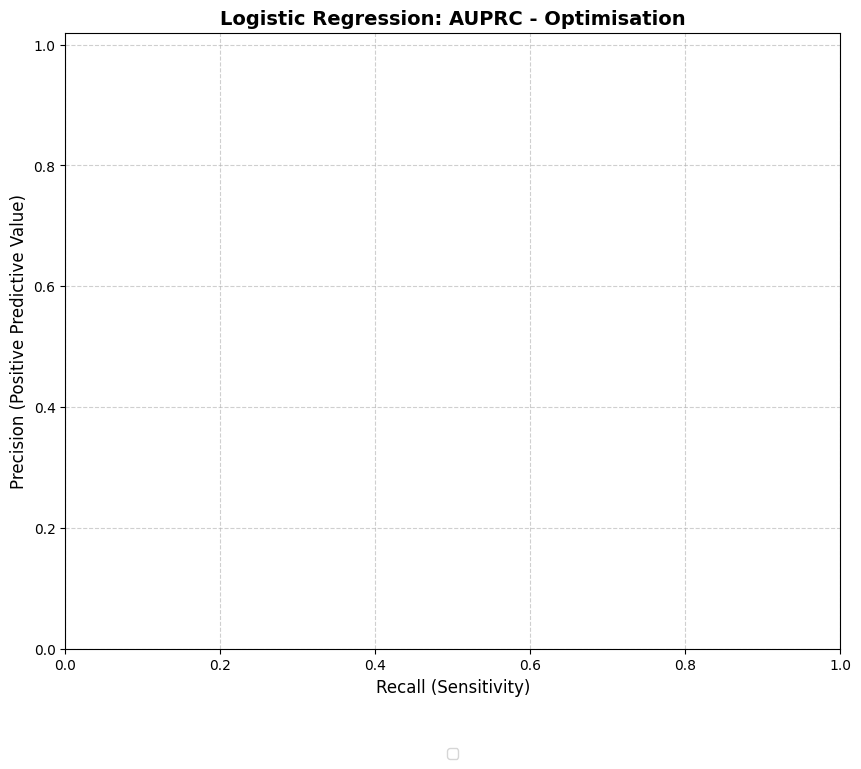


Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251222_163237_Logistic Regression_auprc_c4.png



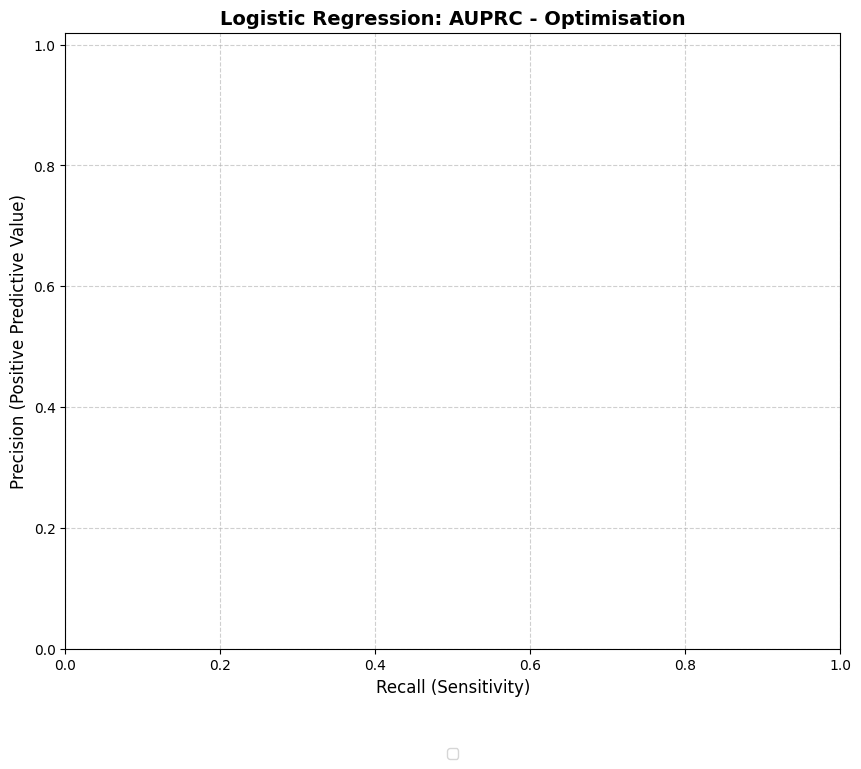

Confusion Matrix plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251222_163237_Logistic Regression_confmatrix.png


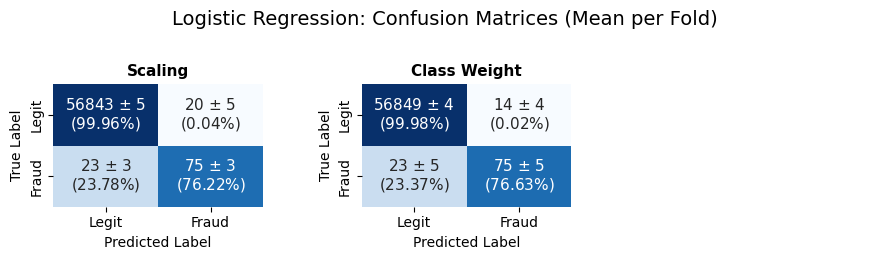

In [61]:
from scipy.stats import uniform, loguniform

# SciKit-Learn LogisticRegression
# (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

# Regularization is applied by default
# Solver liblinear: supports L1 and L2 regularization
# The parameter class_weight is set to 'balanced'
# in case of 'class_weight': True

lr_params = {'C': loguniform(1e-4, 1), # regularization strength
             'penalty': ['l1', 'l2']   # regularization type
             }

lr_df_results, lr_plot_data = run_ablation_study(
    experiment_name="Logistic Regression",
    base_clf=LogisticRegression(
        solver='liblinear',
        dual=False,  # Required for L1 (primal form, more samples than features)
        random_state=137),
    param_dist=lr_params,
    X=X, y=y, configs=configs
)

visualize_results_ablation_study("Logistic Regression", lr_params, lr_df_results, lr_plot_data)



## Section 2D. Implementation of Classifier - XGBoost


--- Starting Experiment: XGBoost ---

2025-12-22 16:33:23 Running Configuration: Scaling

XGBoost scale_pos_weight: 1

XGBoost scale_pos_weight: 1

XGBoost scale_pos_weight: 1

XGBoost scale_pos_weight: 1

XGBoost scale_pos_weight: 1
2025-12-22 16:33:44

| Configuration   |   F1 Score (Mean) |   F1 Score (SD) |   F1 Score (SD%) |   F1 Score (Gap) |   F1 Score (Gap%) |   F2 Score (Mean) |   F2 Score (SD) |   F2 Score (SD%) |   F2 Score (Gap) |   F2 Score (Gap%) |   Recall (Mean) |   Recall (SD) |   Recall (SD%) |   Recall (Gap) |   Recall (Gap%) |   Precision (Mean) |   Precision (SD) |   Precision (SD%) |   Precision (Gap) |   Precision (Gap%) |   AUPRC (Mean) |   AUPRC (SD) |   AUPRC (SD%) |   AUPRC (Gap) |   AUPRC (Gap%) |   Opt Thresh (Mean) |   Opt Thresh (SD) |
|:----------------|------------------:|----------------:|-----------------:|-----------------:|------------------:|------------------:|----------------:|-----------------:|-----------------:|------------------:|------------

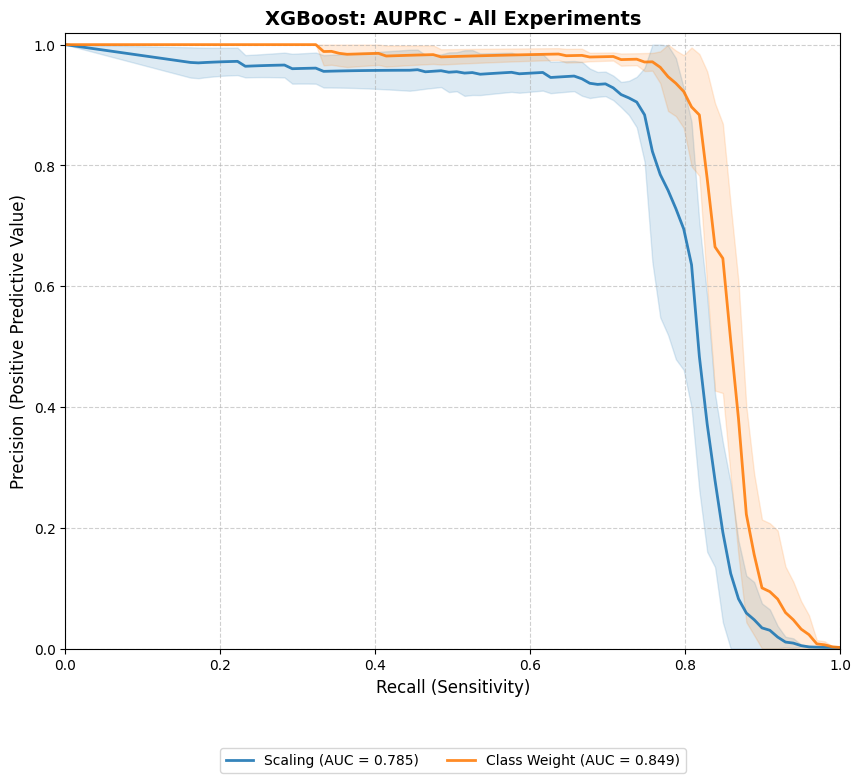

/tmp/ipython-input-1787993024.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2, fontsize=10)



Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251222_163407_XGBoost_auprc_fe_all.png



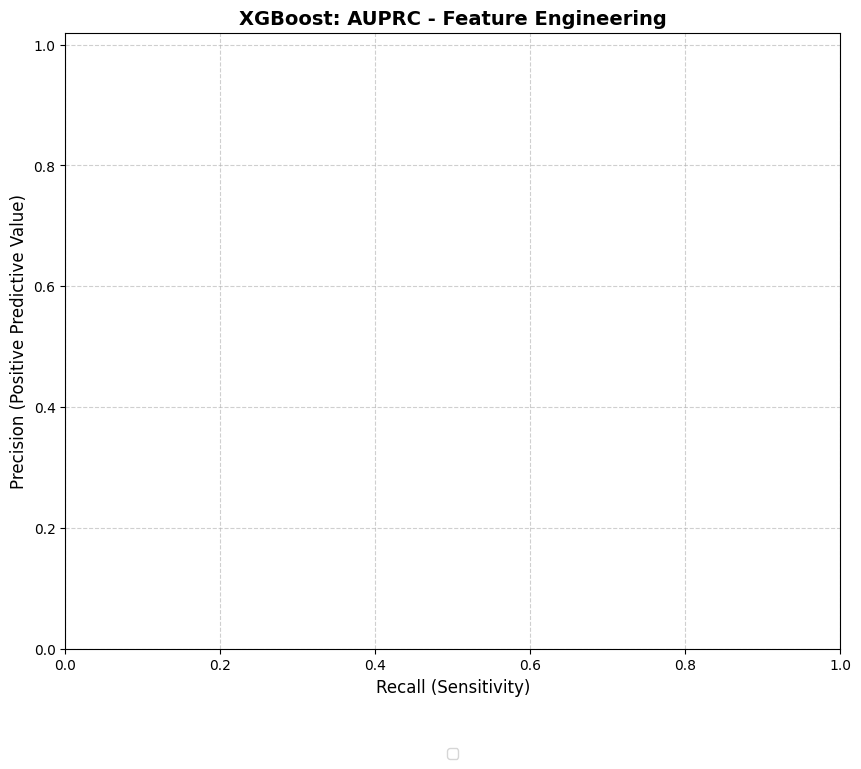


Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251222_163407_XGBoost_auprc_fe_1.png



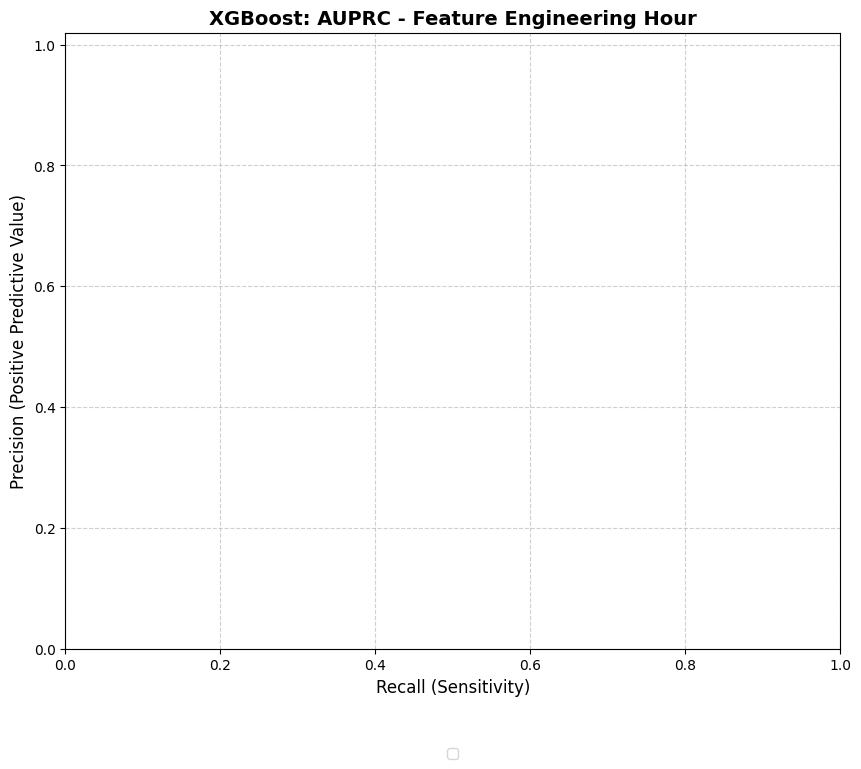


Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251222_163407_XGBoost_auprc_fe_2.png



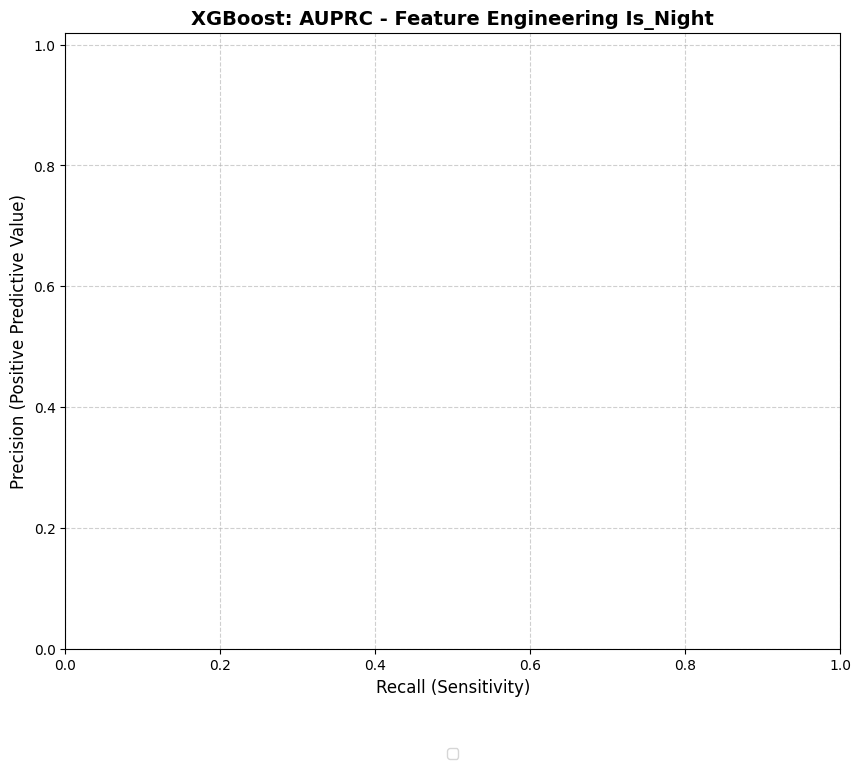


Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251222_163407_XGBoost_auprc_fe_3.png



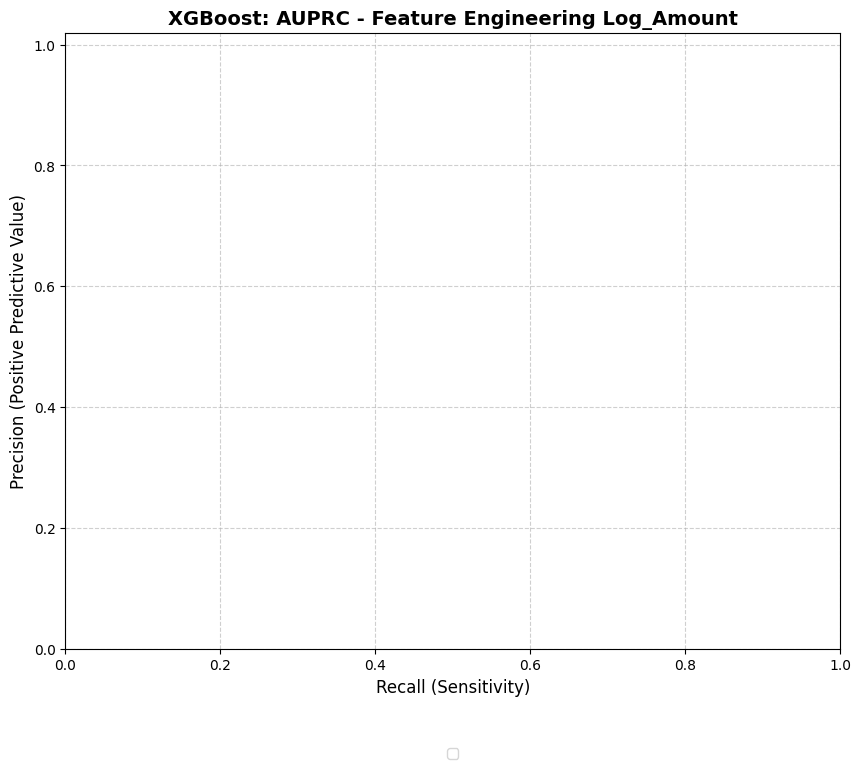


Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251222_163407_XGBoost_auprc_fe_4.png



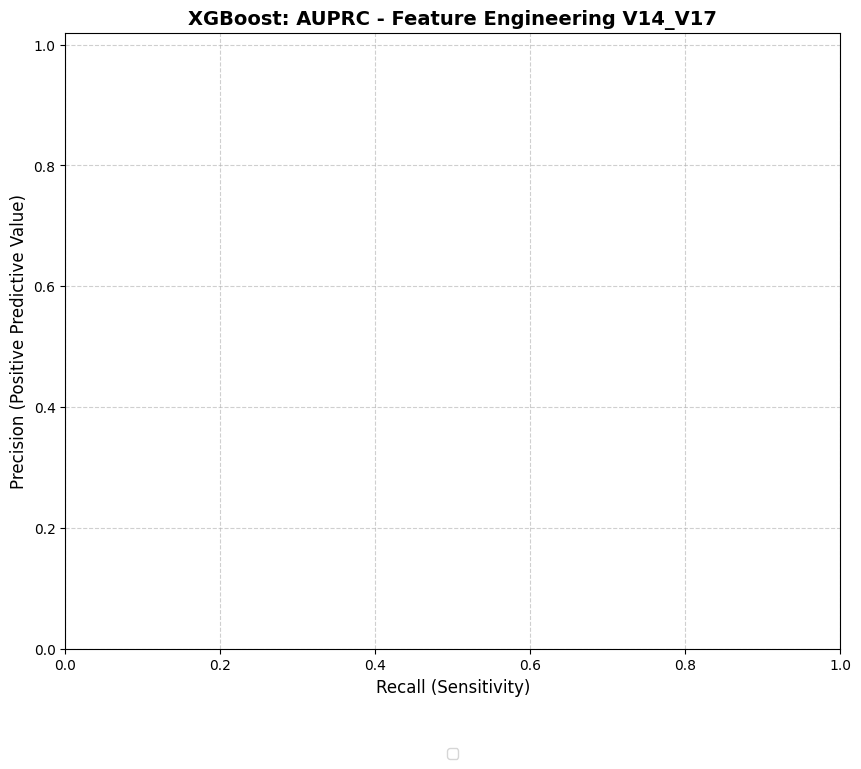


Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251222_163407_XGBoost_auprc_scaling.png



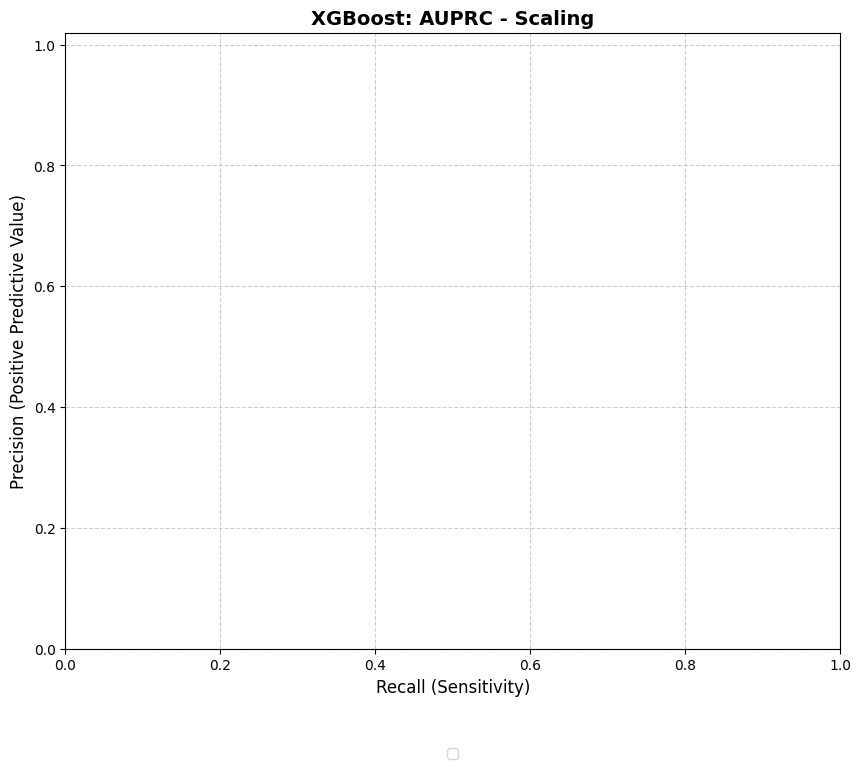


Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251222_163407_XGBoost_auprc_rus.png



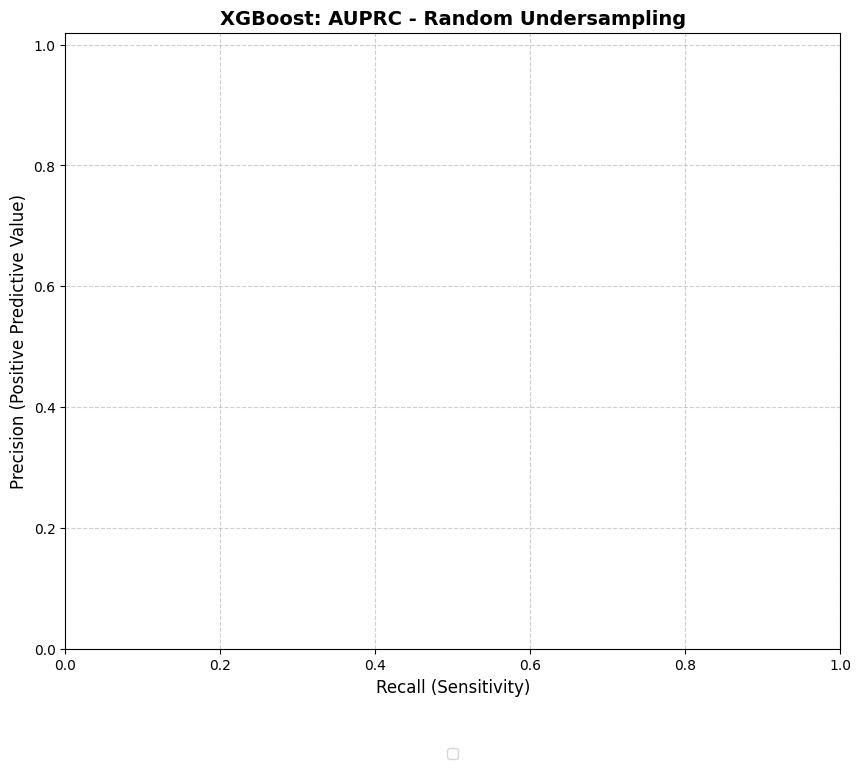


Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251222_163407_XGBoost_auprc_cw.png



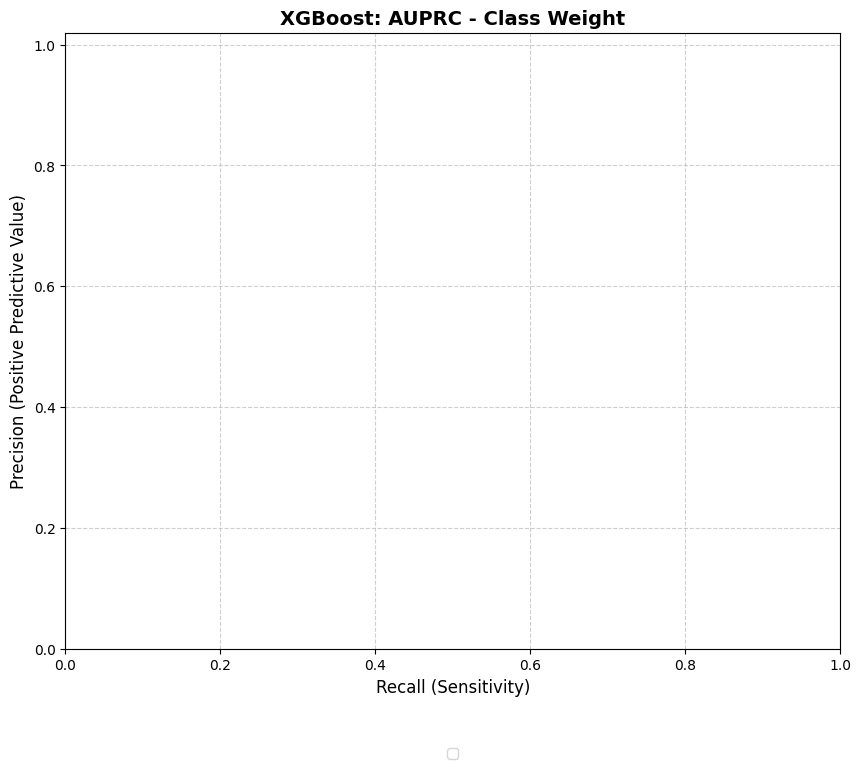


Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251222_163407_XGBoost_auprc_opt.png



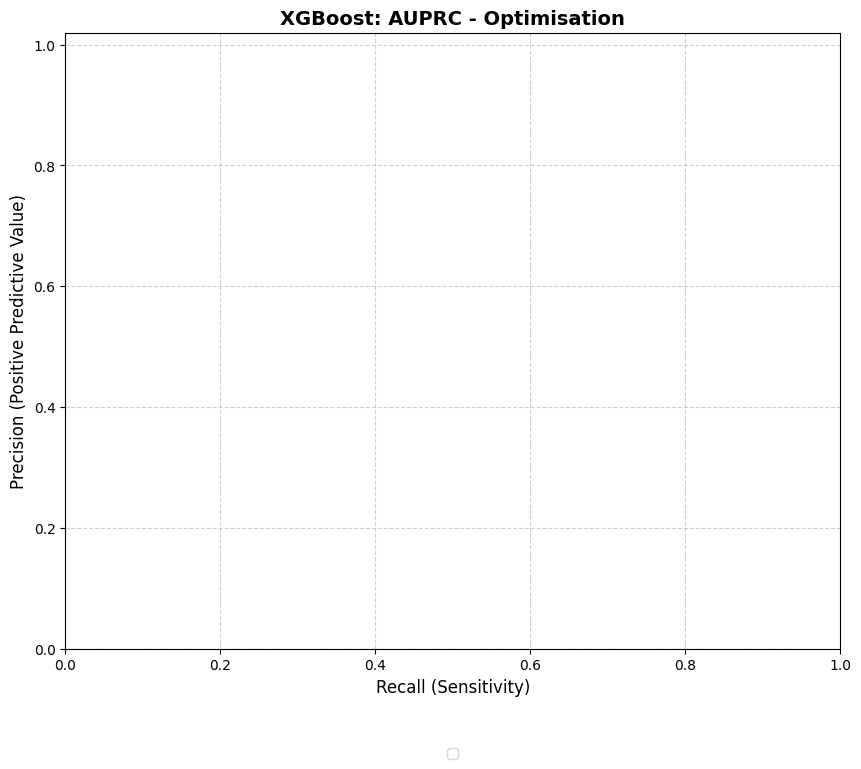


Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251222_163407_XGBoost_auprc_c1.png



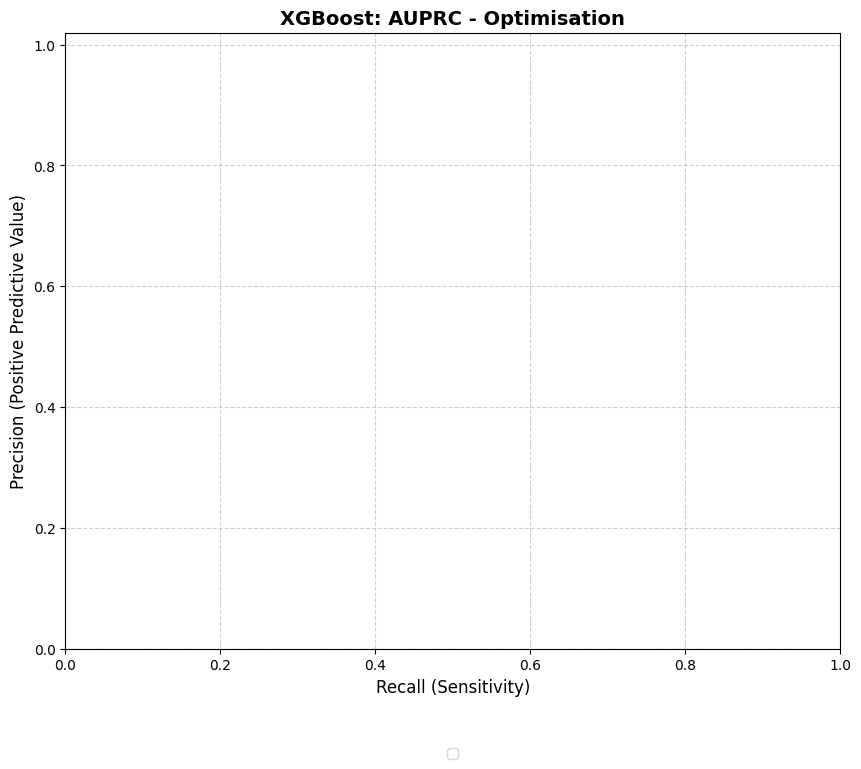


Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251222_163407_XGBoost_auprc_c2.png



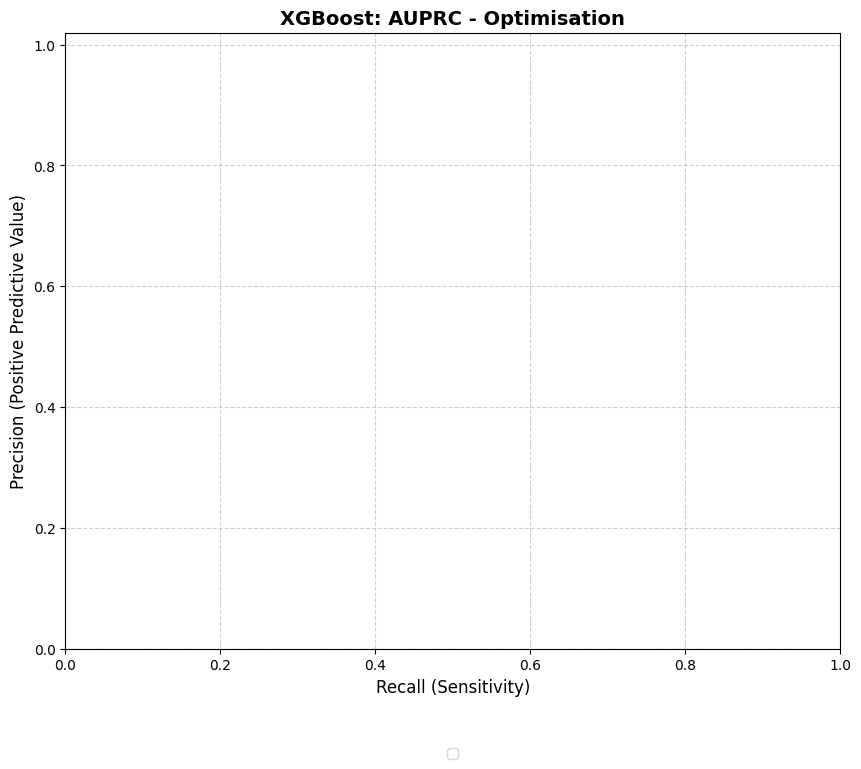


Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251222_163407_XGBoost_auprc_c3.png



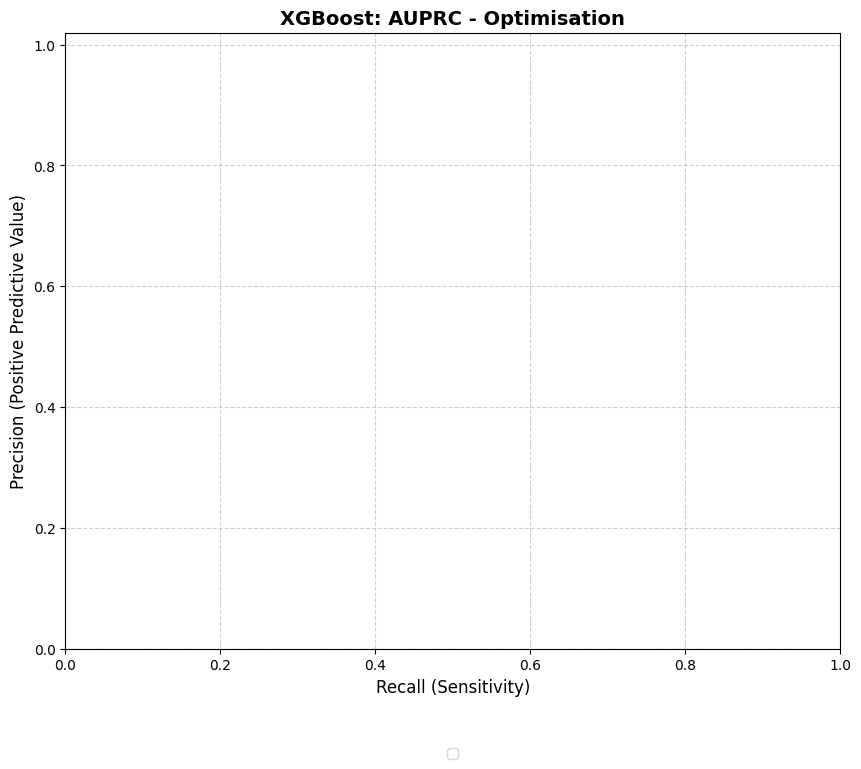


Plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251222_163407_XGBoost_auprc_c4.png



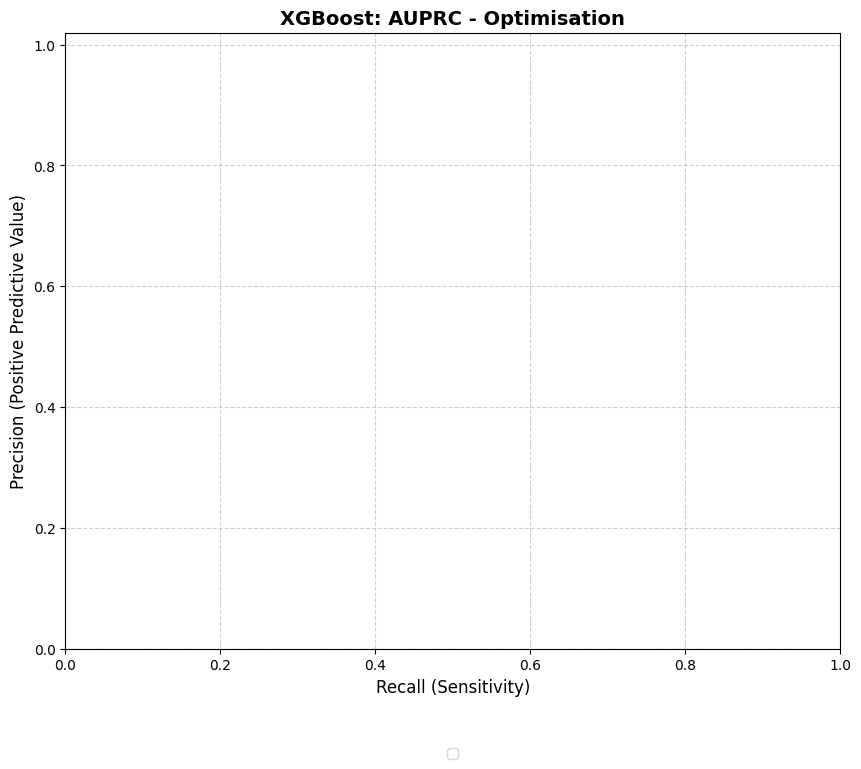

Confusion Matrix plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251222_163407_XGBoost_confmatrix.png


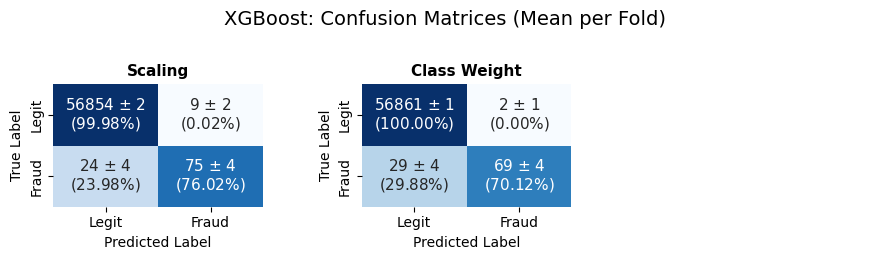

In [62]:
from scipy.stats import randint, uniform, loguniform
from xgboost import XGBClassifier

# XGBoost XGBClassifier
# XGBoost Parameters: https://xgboost.readthedocs.io/en/stable/parameter.html

# The parameter scale_pos_weight is set to legit/fraud ratio 578:1
# in case of 'class_weight': True

xgb_params = {
    'max_depth': randint(3, 6), # Maximum depth of a tree. Increasing this value
                                # will make the model more complex and more
                                # likely to overfit.
    'learning_rate': loguniform(0.01, 0.1),
                                # default 0.3, Step size shrinkage used in
                                # update to prevent overfitting.
    'min_child_weight': randint(20, 50),
                                # default 1, the larger, the more conservative
                                # and prevent overfitting

    'n_estimators': [150],

    # Set minimum loss reduction for regularization
    'gamma': [0.2],  # default 0, Minimum loss reduction required
                    # to make a further partition on a leaf node of the tree.
                    # The larger gamma is, the more conservative the algorithm
                    # will be.

    # Train each tree only on 70% of data / columns to prevent overvitting
    'subsample': [0.7], # default 1, subsample ratio of the training instances
                        # (per boosting iteration)
    'colsample_bytree': [0.7] # default 1, subsample ratio of columns when
                              # constructing each tree.
}

xgb_df_results, xgb_plot_data = run_ablation_study(
    experiment_name="XGBoost",
    base_clf=XGBClassifier(eval_metric='logloss', random_state=173, n_jobs=1),
      # eval_metric='logloss' - eval metric for learning, logloss (negative log-likelihood, suitable for classification)
    param_dist=xgb_params,
    X=X, y=y, configs=configs
)

visualize_results_ablation_study("XGBoost", xgb_params, xgb_df_results, xgb_plot_data)



## Section 2E. Comparison of Classifiers
Select best performing classifier by AUPRC


=== Classifier Comparison Results: Classifier comparison ===

Date: 20251222_164013


--- Metrics ---

| Configuration                 |   F1 Score (Mean) |   F1 Score (SD) |   F1 Score (SD%) |   F1 Score (Gap) |   F1 Score (Gap%) |   F2 Score (Mean) |   F2 Score (SD) |   F2 Score (SD%) |   F2 Score (Gap) |   F2 Score (Gap%) |   Recall (Mean) |   Recall (SD) |   Recall (SD%) |   Recall (Gap) |   Recall (Gap%) |   Precision (Mean) |   Precision (SD) |   Precision (SD%) |   Precision (Gap) |   Precision (Gap%) |   AUPRC (Mean) |   AUPRC (SD) |   AUPRC (SD%) |   AUPRC (Gap) |   AUPRC (Gap%) |   Opt Thresh (Mean) |   Opt Thresh (SD) |
|:------------------------------|------------------:|----------------:|-----------------:|-----------------:|------------------:|------------------:|----------------:|-----------------:|-----------------:|------------------:|----------------:|--------------:|---------------:|---------------:|----------------:|-------------------:|-----------------:|---------

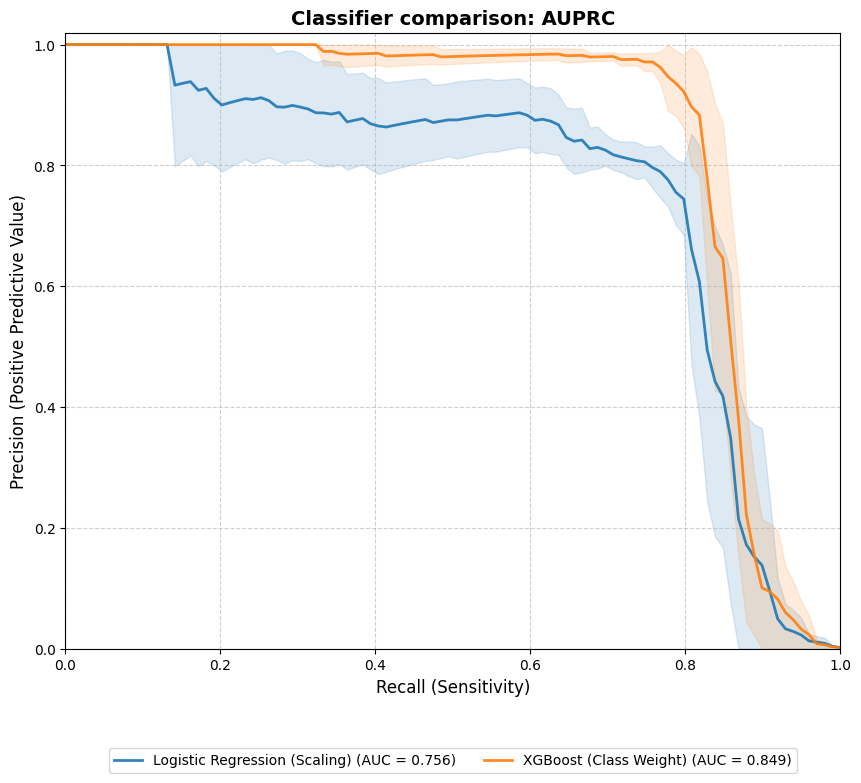

Confusion Matrix plot saved to: /content/drive/MyDrive/Colab_Results/creditcardfraud/20251222_164013_Classifier comparison_clcomp_confmatrix.png


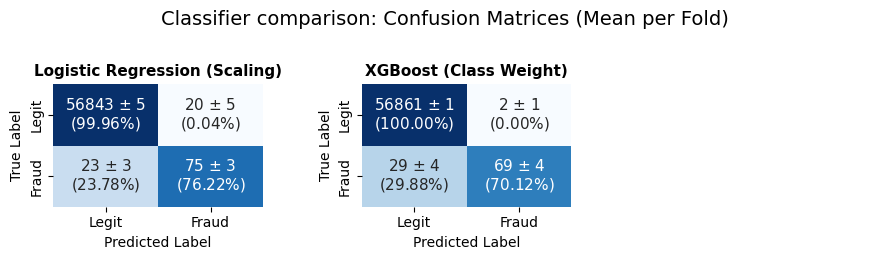

In [67]:
import pandas as pd

# Find Logistic Regression best result (best AUPRC)
lr_best_idx = pd.to_numeric(lr_df_results['AUPRC (Mean)']).idxmax()
lr_best_config_name = lr_df_results.loc[lr_best_idx, 'Configuration']
lr_new_name = f"Logistic Regression ({lr_best_config_name})"
lr_best_df = lr_df_results.iloc[[lr_best_idx]].copy()
lr_best_df['Configuration'] = lr_new_name
lr_best_plot = {lr_new_name: lr_plot_data[lr_best_config_name]}

# Find XGBoost best result (best AUPRC)
xgb_best_idx = pd.to_numeric(xgb_df_results['AUPRC (Mean)']).idxmax()
xgb_best_config_name = xgb_df_results.loc[xgb_best_idx, 'Configuration']
xgb_new_name = f"XGBoost ({xgb_best_config_name})"
xgb_best_df = xgb_df_results.iloc[[xgb_best_idx]].copy()
xgb_best_df['Configuration'] = xgb_new_name
xgb_best_plot = {xgb_new_name: xgb_plot_data[xgb_best_config_name]}

# Combine and visualize
combined_results = pd.concat([lr_best_df, xgb_best_df], ignore_index=True)
combined_plot_data = {**lr_best_plot, **xgb_best_plot}
visualize_results_classifier_comparison("Classifier comparison", combined_results, combined_plot_data)